In [1]:

# Import Libraries
import pandas as pd
import numpy as np
import os
from dask import dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta

def ConvertDate(string):
    date = pd.to_datetime(string, format='%Y-%m-%d')
    return date

def displayDataFrame(df):
    with pd.option_context('display.max_columns', None):
        display(df)
    
def SummaryDataFrame(df, ConditionName):
    print('-----------------------------')
    print('\033[1m' + ConditionName.upper() + '\033[0m')
    print('\033[1m Columns: \033[0m')
    print(df.columns)
    print('\033[1m Size of dataset: \033[0m', df.shape)
    displayDataFrame(df.head(2))


In [ ]:

# Open datasets with flagged errors

def OpenFile(dataset):
    print('Reading', dataset, 'dataset...')
    Path = r"O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Data\1_Processed"
    FileName = dataset + '_SpellLevel_FeatureEngineered.csv'
    FilePath = os.path.join(Path, FileName)
    df_dataset = pd.read_csv(FilePath)
    
    return df_dataset

df_Autism_ini = OpenFile('Autism')
SummaryDataFrame(df_Autism_ini, 'Autism')

# df_Dementia_ini = OpenFile('Dementia')
# df_Diabetes_ini = OpenFile('Diabetes')

# SummaryDataFrame(df_Dementia_ini, 'Dementia')
# SummaryDataFrame(df_Diabetes_ini, 'Diabetes')


Reading Autism dataset...


In [28]:

# Process and Encode features
# --------------------------------------------------
def ProcessAndEncode(df_ini, ConditionName):
    df = df_ini.copy()
    ErrorName = 'SpellLevel_Error_'+ConditionName

    # Only keep readmissions (SpellLevel_TimeDiff>0)
    Filter_SubsequentSpell = (df.loc[:, 'SubsequentSpell']==1)
    df = df.loc[Filter_SubsequentSpell, :].drop(columns=['SubsequentSpell'])
    
    # Select Features
    ColumnList = ['sex', 'age_of_patient', 'Ethnicity',
                   'diagnosis_group',
                   'ProvCode', 'FirstSpell_ProvCode', 
                   'Main_Specialty_Description',
                   'Spell_Los', 'Spell_Los_0', 'MORT', 'Read30', 'Read90',
                   'POD_Emergency', # POD_Elective
                   'FirstSpell_ProvCode_PrivateProv', 'ProvCode_PrivateProv',
                   'Change_ProvCode', 'Change_ProvCode_Type', 'Change_Region', 'Change_Main_Specialty_Description',
                   'Missing_Age', 'Missing_IMD_Score', 'Missing_POD',
                   'HFRS_Score', 'IMD_Score',
                   'TimeDiff_FirstSpell',
                    ErrorName]

    for col in ColumnList:
        if not(col in df.columns):
            print(col)

    df = df.loc[:, ColumnList]
    
    # Encoding Read30 and Read90
    Filter_Read30 = df.loc[:, 'Read30']=='Y'
    df.loc[:, 'Read30'] = np.where(Filter_Read30, 1, 0)
    Filter_Read90 = df.loc[:, 'Read90']=='Y'
    df.loc[:, 'Read90'] = np.where(Filter_Read90, 1, 0)
    
    # Correct missing age
    Filter_NotMissingAge = df.loc[:, 'age_of_patient']!=999
    MeanAge = df.loc[Filter_NotMissingAge, 'age_of_patient'].median()
    df.loc[~Filter_NotMissingAge, 'age_of_patient'] = MeanAge

    # Set dtypes
    Features_Int = ['TimeDiff_FirstSpell', 'age_of_patient'] # 'Read3Years_SinceFirst', 'MORT3Years_SinceFirst', 'NumberErrors_3YearsSinceFirst']
    d_FeaturesInt = {}
    for feature_int in Features_Int:
        d_FeaturesInt[feature_int]=int
    df = df.astype(d_FeaturesInt)
    
    # One-hot encoding
    ColumnNames = ['sex', 'Ethnicity', 'Region']
    df_Encoded = df
    for col in ColumnNames:
        if col in df_Encoded.columns:
            df_Encoded = pd.get_dummies(df_Encoded, prefix=col+'_', columns=[col], drop_first=True)
    FeatureList = list(df_Encoded.columns)
    FeatureList_Ordered = [x for x in FeatureList if x!='SpellLevel_Error_'+ConditionName] + ['SpellLevel_Error_'+ConditionName]
    df_Encoded = df_Encoded.loc[:, FeatureList_Ordered]
    
    # Region: Non-NHS provider
#     Filter_NHS = df_Encoded.loc[:, 'ProvCode'].str.startswith('R')
#     df_Encoded.loc[:, 'ProvCode_PrivateProv'] = np.where(Filter_NHS, 0, 1)
#     Filter_NHSFirst = df_Encoded.loc[:, 'FirstSpell_ProvCode'].str.startswith('R')
#     df_Encoded.loc[:, 'FirstSpell_ProvCode_PrivateProv'] = np.where(Filter_NHSFirst, 0, 1)
        
    # SPECIFIC TO DEMENTIA
    if ConditionName=='Dementia':
        # Main specialty
        CommonSpecialties_List = ['geriatric medicine', 'general medicine']
        CommonSpecialties_String = '|'.join(CommonSpecialties_List)
        Filter_CommonSpecialties = df_Encoded.loc[:, 'Main_Specialty_Description'].str.contains(CommonSpecialties_String)
        df_Encoded.loc[:, 'Main_Specialty_GeriatricGeneral'] = np.where(Filter_CommonSpecialties, 1, 0)
        # Parkinson G20
        df_Encoded.loc[:, 'SpellLevel_ICD10_Parkinson'] = df_ini.loc[:, 'SpellLevel_ICD10_Parkinson']
        # Remove <40 year-old patients
        Filter_Age = df_Encoded.loc[:, 'age_of_patient']>=40
        df_Encoded = df_Encoded.loc[Filter_Age, :]
        
    # SPECIFIC TO AUTISM
    elif ConditionName=='Autism':
        # Main specialty
        CommonSpecialties_List = ['paediatrics', 'general medicine']
        CommonSpecialties_String = '|'.join(CommonSpecialties_List)
        Filter_CommonSpecialties = df_Encoded.loc[:, 'Main_Specialty_Description'].str.contains(CommonSpecialties_String)
        df_Encoded.loc[:, 'Main_Specialty_PaediatricsGeneral'] = np.where(Filter_CommonSpecialties, 1, 0)
        # Learning Disabilities
#         Codes_LearningDisabilities = ['F7' + i + x for i in ['0', '1', '2', '3', '8', '9'] for x in ['0', '1', '8', '9']]
#         Codes_LearningDisabilities = Codes_LearningDisabilities + ['F8' + i + x for i in ['0', '1'] for x in ['0', '1', '2', '3', '8', '9']]
#         Codes_LearningDisabilities = Codes_LearningDisabilities + ['F82', 'F83'] + ['F842', 'F844', 'F848', 'F849', 'F88', 'F89']
        Codes_LearningDisabilities = ['F7' + i for i in ['0', '1', '2', '3', '8', '9']]
        Codes_LearningDisabilities_str = '|'.join(Codes_LearningDisabilities)
        Filter_LearningDisabilities = df_Encoded.loc[:, 'diagnosis_group'].str.contains(Codes_LearningDisabilities_str)
        df_Encoded.loc[:, 'SpellLevel_ICD10_LearningDisabilities'] = np.where(Filter_LearningDisabilities, 1, 0)
            
    # Drop final columns
    ColumnsDrop = ['ProvCode', 'FirstSpell_ProvCode', 'Main_Specialty_Description',
                   'Read90', 'Ethnicity__not known',
                   'diagnosis_group']
    ColumnsDrop_in = [x for x in ColumnsDrop if x in df_Encoded.columns]
    df_Encoded = df_Encoded.drop(columns=ColumnsDrop_in)
    

    return df_Encoded
# --------------------------------------------------

df_Autism_Encoded = ProcessAndEncode(df_Autism_ini, "Autism")
SummaryDataFrame(df_Autism_Encoded, 'Autism')

# df_Dementia_Encoded = ProcessAndEncode(df_Dementia_ini, "Dementia")
# SummaryDataFrame(df_Dementia_Encoded, 'Dementia')

# df_Diabetes_Encoded = ProcessAndEncode(df_Diabetes_ini, "Diabetes")
# SummaryDataFrame(df_Diabetes_Encoded, 'Diabetes')


-----------------------------
AUTISM
 Columns: 
Index(['age_of_patient', 'Spell_Los', 'Spell_Los_0', 'MORT', 'Read30',
       'POD_Emergency', 'FirstSpell_ProvCode_PrivateProv',
       'ProvCode_PrivateProv', 'Change_ProvCode', 'Change_ProvCode_Type',
       'Change_Region', 'Change_Main_Specialty_Description', 'Missing_Age',
       'Missing_IMD_Score', 'Missing_POD', 'HFRS_Score', 'IMD_Score',
       'TimeDiff_FirstSpell', 'sex__Male', 'Ethnicity__black or black british',
       'Ethnicity__mixed', 'Ethnicity__other ethnic groups',
       'Ethnicity__white', 'SpellLevel_Error_Autism',
       'Main_Specialty_PaediatricsGeneral',
       'SpellLevel_ICD10_LearningDisabilities'],
      dtype='object')
 Size of dataset:  (397705, 26)


,age_of_patient,Spell_Los,Spell_Los_0,MORT,Read30,POD_Emergency,FirstSpell_ProvCode_PrivateProv,ProvCode_PrivateProv,Change_ProvCode,Change_ProvCode_Type,Change_Region,Change_Main_Specialty_Description,Missing_Age,Missing_IMD_Score,Missing_POD,HFRS_Score,IMD_Score,TimeDiff_FirstSpell,sex__Male,Ethnicity__black or black british,Ethnicity__mixed,Ethnicity__other ethnic groups,Ethnicity__white,SpellLevel_Error_Autism,Main_Specialty_PaediatricsGeneral,SpellLevel_ICD10_LearningDisabilities
1,55,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,14.369,1176,1,0,0,0,1,1,0,0
3,13,3,0,0,0,1,1,0,1,1,1,0,0,0,0,0.0,14.999,479,1,0,0,0,1,1,0,0


In [29]:

# Visualise correlations between features
M = df_Autism_Encoded.corr().abs()
df_corr = M.stack().reset_index().rename(columns={'level_0':'Feature_1',
                                                  'level_1':'Feature_2',
                                                  0:'Correlation'})
Threshold = 0.7
Filter_Threshold = (df_corr.loc[:, 'Correlation']<1) & (df_corr.loc[:, 'Correlation']>=Threshold)
df_corr = df_corr.loc[Filter_Threshold, :]
if df_corr.shape[0]==0:
    print('No highly-correlated pairs.')
else:
    displayDataFrame(df_corr)


No highly-correlated pairs.


# Implement Classifier

In [30]:

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, accuracy_score, make_scorer
from sklearn.inspection import permutation_importance


In [31]:

# Split dataset
# --------------------------------------------------
def TrainTestSplit(df_ini, ConditionName):
    df = df_ini
    
    
    
    y_ini = df.loc[:, 'SpellLevel_Error_'+ConditionName]
    X_ini = df.drop(columns=['SpellLevel_Error_'+ConditionName])
    
    # Add random variables: binary and continuous
    rng = np.random.RandomState(seed=42)
    X_ini["RANDOM_cat"] = rng.randint(2, size=X_ini.shape[0])
    X_ini["RANDOM_num"] = rng.randn(X_ini.shape[0])
    
    # Test: dropping column with feature importance <= 1% max
#     ColumnsImportant = ['SpellLevel_ICD10_Parkinson',
#                  'POD_Emergency',
#                  'age_of_patient',
#                  'Main_Specialty_GeriatricGeneral',
#                  'TimeDiff_FirstSpell',
#                  'IMD_Score',
#                  'Change_ProvCode',
#                  'sex__Male',
#                  'Ethnicity__white',
#                  'Read30',
#                  'Change_Main_Specialty_Description',
#                  'Spell_Los_0']
#     X_ini = X_ini.loc[:, ColumnsImportant]
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_ini, y_ini, test_size=0.15, stratify=y_ini, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.15/0.85)
    
    print("\n \033[1m", ConditionName.upper(),'\033[0m :')
    print('Size of training set:', X_train.shape, 'corresponding to %0.2f' % (100*X_train.shape[0]/X_ini.shape[0]), '%')
    print('Size of validation set:', X_val.shape, 'corresponding to %0.2f' % (100*X_val.shape[0]/X_ini.shape[0]), '%')
    print('Size of test set:', X_test.shape, 'corresponding to %0.2f' % (100*X_test.shape[0]/X_ini.shape[0]), '%')
    print('List of features:', X_train.columns)
    
    return X_ini, y_ini, X_trainval, y_trainval, X_train, X_val, X_test, y_train, y_val, y_test
# --------------------------------------------------

X_ini_Autism, y_ini_Autism, X_trainval_Autism, y_trainval_Autism, X_train_Autism, X_val_Autism, X_test_Autism, y_train_Autism, y_val_Autism, y_test_Autism = TrainTestSplit(df_Autism_Encoded, "Autism")
# X_ini_Dementia, y_ini_Dementia, X_train_Dementia, X_val_Dementia, X_test_Dementia, y_train_Dementia, y_val_Dementia, y_test_Dementia = TrainTestSplit(df_Dementia_Encoded, "Dementia")
# X_ini_Diabetes, y_ini_Diabetes, X_train_Diabetes, X_val_Diabetes, X_test_Diabetes, y_train_Diabetes, y_val_Diabetes, y_test_Diabetes = TrainTestSplit(df_Diabetes_Encoded, "Diabetes")



  AUTISM  :
Size of training set: (278393, 27) corresponding to 70.00 %
Size of validation set: (59656, 27) corresponding to 15.00 %
Size of test set: (59656, 27) corresponding to 15.00 %
List of features: Index(['age_of_patient', 'Spell_Los', 'Spell_Los_0', 'MORT', 'Read30',
       'POD_Emergency', 'FirstSpell_ProvCode_PrivateProv',
       'ProvCode_PrivateProv', 'Change_ProvCode', 'Change_ProvCode_Type',
       'Change_Region', 'Change_Main_Specialty_Description', 'Missing_Age',
       'Missing_IMD_Score', 'Missing_POD', 'HFRS_Score', 'IMD_Score',
       'TimeDiff_FirstSpell', 'sex__Male', 'Ethnicity__black or black british',
       'Ethnicity__mixed', 'Ethnicity__other ethnic groups',
       'Ethnicity__white', 'Main_Specialty_PaediatricsGeneral',
       'SpellLevel_ICD10_LearningDisabilities', 'RANDOM_cat', 'RANDOM_num'],
      dtype='object')


## Tuning classifier

In [32]:

# Define classifier to optimise
clf_RF = RandomForestClassifier()

# --------------------------------------------------
def OptimisationRF(clf, X_val, y_val, random_grid, ConditionName):
    print('Optimising \033[1m', ConditionName.upper(), '\033[0m classifier...')

    # Define CV
    CV = StratifiedKFold(n_splits=3, random_state=None)
    
    # Define metrics of interest: AUROC - AUPR Curve
    metric_ROC_auc = 'roc_auc'

    def metric_PR_auc(y_true, probas_pred):
        p, r, _ = precision_recall_curve(y_true, probas_pred)
        return auc(r, p)
    metric_PR_auc = make_scorer(metric_PR_auc, needs_proba=True)
    
    Scoring = metric_PR_auc

    # Random search training
    clf_RF_random = RandomizedSearchCV(estimator=clf_RF,
                                        param_distributions=random_grid,
                                        n_iter=20,
                                        cv=CV,
                                        verbose=2,
                                        random_state=42,
                                        n_jobs=-1,
                                        scoring='roc_auc')
    
    clf_RF_random.fit(X_val, y_val)
    
    print(ConditionName.upper(), ': DONE')
    print(clf_RF_random.best_params_)
    
    return clf_RF_random
# --------------------------------------------------

# Initialise classifiers
clf_RF_Dementia = RandomForestClassifier()
clf_RF_Autism = RandomForestClassifier()
clf_RF_Diabetes = RandomForestClassifier()

# Construct grid of parameters
n_estimators = [int(x) for x in np.linspace(100, 300, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(60, 100, 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

random_grid_long = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap,
               'class_weight':class_weight}

random_grid_short = {'n_estimators':n_estimators,
                     'max_features':max_features,
                     'max_depth':max_depth}

RunOptimisation = True
if RunOptimisation:
    # Optimise classifiers on validation sets
    clf_RF_Autism_gridSearch = OptimisationRF(clf_RF_Autism, X_trainval_Autism, y_trainval_Autism, random_grid_long, 'Autism')
    # clf_RF_Dementia_gridSearch = OptimisationRF(clf_RF_Dementia, X_val_Dementia, y_val_Dementia, random_grid_long, 'Dementia')



Optimising  AUTISM  classifier...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
AUTISM : DONE
{'n_estimators': 295, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 95, 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [33]:

# Define optimised classifier
# clf_RF_Autism_Optimised = RandomForestClassifier(n_estimators=295,
#                                 min_samples_split=2,
#                                 min_samples_leaf=2,
#                                 max_depth=95,
#                                 max_features='auto',
#                                 bootstrap=False,
#                                 class_weight='balanced_subsample')

clf_RF_Autism_Optimised = clf_RF_Autism_gridSearch.best_estimator_


In [34]:

print('Training on AUTISM dataset...')
clf_RF_Autism_Optimised = clf_RF_Autism_Optimised.fit(X_trainval_Autism, y_trainval_Autism)
# clf_RF_Autism_Optimised = clf_RF_Autism_Optimised.fit(X_train_Autism, y_train_Autism)
# print('Training on DEMENTIA dataset...')
# clf_RF_Dementia_Optimised = clf_RF_Dementia_Optimised.fit(X_train_Dementia, y_train_Dementia)
# print('Training on DIABETES dataset...')
# clf_RF_Diabetes = clf_RF_Diabetes_Optimised.fit(X_train_Diabetes, y_train_Diabetes)
print('Training: \033[1m DONE \033[0m')


Training on AUTISM dataset...
Training:  DONE 



 +  AUTISM 
ROC Score: 0.79
Accuracy: 0.71


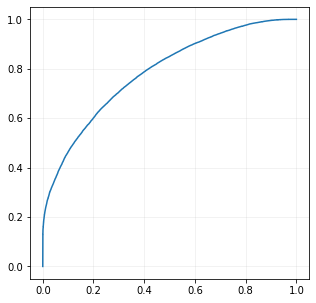

In [35]:

# Calculate ROC score and plot ROC characteristic
# --------------------------------------------------
def fit_ROC(clf_RF, X_test, y_test, ConditionName):
    y_proba = clf_RF.predict_proba(X_test)[:, 1]
    ROC_Score = roc_auc_score(y_test, y_proba)
    print('\n + \033[1m', ConditionName.upper(), '\033[0m')
    print('ROC Score: %0.2f' % ROC_Score)
    print('Accuracy: %0.2f' % accuracy_score(clf_RF.predict(X_test), y_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.grid('on', alpha=0.2)
# --------------------------------------------------

fit_ROC(clf_RF_Autism_Optimised, X_test_Autism, y_test_Autism, 'Autism')
# fit_ROC(clf_RF_Dementia_Optimised, X_test_Dementia, y_test_Dementia, 'Dementia')
# fit_ROC(clf_RF_Diabetes_Optimised, X_test_Diabetes, y_test_Diabetes, 'Diabetes')


## Feature importance: Permutation using rfpimp

In [36]:
import import_ipynb
import rfpimp

def FeatureImportance_rfpimp(clf, X, y, ConditionName):
    I = rfpimp.permutation_importances(clf, X, y, rfpimp.oob_classifier_accuracy)
    
    I.plot.bar(rot='90', title=ConditionName);
    return I
    
FeatureImportance_rfpimp_Autism = FeatureImportance_rfpimp(clf_RF_Autism_Optimised, 
                                                             X_test_Autism, y_test_Autism, 'Autism')


ModuleNotFoundError: No module named 'rfpimp'

## Feature importance: Permutation using sklearn

age_of_patient                           0.108365
IMD_Score                                0.069056
Change_ProvCode                          0.060326
TimeDiff_FirstSpell                      0.046949
sex__Male                                0.035732
Change_Main_Specialty_Description        0.033536
POD_Emergency                            0.030448
Ethnicity__white                         0.025168
Main_Specialty_PaediatricsGeneral        0.022274
Change_Region                            0.016303
SpellLevel_ICD10_LearningDisabilities    0.014892
Spell_Los                                0.011928
HFRS_Score                               0.005632
Spell_Los_0                              0.005009
Read30                                   0.004311
Ethnicity__other ethnic groups           0.003865
Ethnicity__black or black british        0.001797
Ethnicity__mixed                         0.001244
RANDOM_num                               0.000667
RANDOM_cat                               0.000530


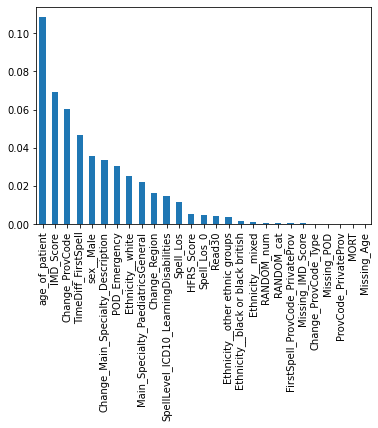

In [37]:

FeatureImportance_sklearn(clf_RF_Autism_Optimised, X_test_Autism, y_test_Autism)


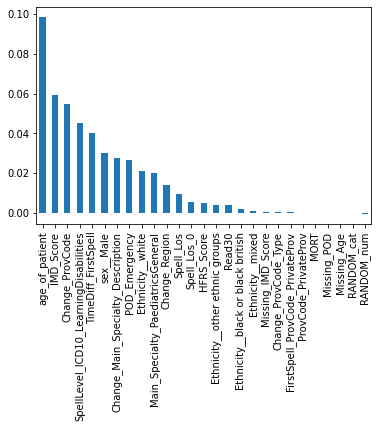

In [11]:

def FeatureImportance_sklearn(clf, X, y):
    I_Autism = permutation_importance(clf, X, y)
    Features = X.columns
    FeatureImportance_Series = pd.Series(I_Autism['importances_mean'], index=Features).sort_values(ascending=False)
    
    FeatureImportance_Series.plot.bar()
    return FeatureImportance_Series

FeatureImportance_sklearn_Autism = FeatureImportance_sklearn(clf_RF_Autism_Optimised, X_test_Autism, y_test_Autism)


In [12]:

FeatureImportance_sklearn_Autism.iloc[0:10]


age_of_patient                           0.098589
IMD_Score                                0.059334
Change_ProvCode                          0.054623
SpellLevel_ICD10_LearningDisabilities    0.045209
TimeDiff_FirstSpell                      0.040301
sex__Male                                0.030113
Change_Main_Specialty_Description        0.027608
POD_Emergency                            0.026646
Ethnicity__white                         0.020987
Main_Specialty_PaediatricsGeneral        0.020146
dtype: float64

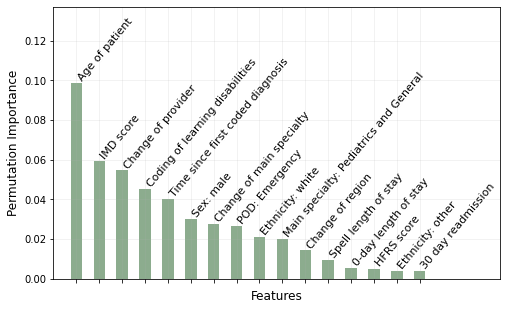

In [26]:

fig, ax = plt.subplots(figsize=(8,5))
df_FeatureImportance = pd.DataFrame({'Feature':FeatureImportance_sklearn_Autism.index,
                                     'Importance':FeatureImportance_sklearn_Autism.values})

FeatureLabels_New = ["Age of patient",
                     "IMD score",
                     "Change of provider",
                     "Coding of learning disabilities",
                     "Time since first coded diagnosis",
                     "Sex: male",
                     "Change of main specialty",
                     "POD: Emergency",
                     "Ethnicity: white",
                     "Main specialty: Pediatrics and General",
                     "Change of region",
                     "Spell length of stay",
                     "0-day length of stay",
                     "HFRS score",
                     "Ethnicity: other",
                     "30 day readmission"]
# FeatureLabels = FeatureLabels_New + list(df_FeatureImportance.loc[:, 'Feature'].values)[len(FeatureLabels_New):]
FeatureLabels = FeatureLabels_New

for index, value in enumerate(FeatureLabels):
    plt.text(index, 0.001+df_FeatureImportance.loc[index, 'Importance'], str(value),
             rotation='50', weight='normal', size=11,
             zorder=2) #, color=ColorText
    
Color1 = (26/255, 90/255, 30/255)
FeatureImportance_sklearn_Autism[0:len(FeatureLabels)].plot.bar(color=Color1, alpha=0.5);

plt.grid('on', alpha=0.2)
plt.ylim(0, 0.137)
plt.xlim(-1, 18.5)
ax.set_xticklabels([]);
plt.xlabel('Features', size=12);
plt.ylabel('Permutation Importance', size=12);
# plt.title("Errors related Dementia: Important Features", size=14, fontweight='bold');

SaveFig = True
if SaveFig:
    plt.savefig(r'O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Figures\Autism_PermutationImportance_21.12.07.png',
               bbox_inches='tight', format='png', dpi=300)


# Compute and visualise Shapley values

In [ ]:

import shap

# Create Tree Explainer object that can calculate shap values
def ComputeShapValues(clf, X_test):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)
    return shap_values

shap_values_Autism = ComputeShapValues(clf_RF_Autism_Optimised, X_test_Autism)


In [ ]:

def ShapSummaryPlotImportantFeatures(shap_values, X_test, ImportantFeatures_List):
    Features_Number = range(1, len(X_test.columns)+1)
    df_Features = pd.DataFrame({'Feature':list(X_test.columns), 'Number':Features_Number})
    Filter = df_Features.loc[:, 'Feature'].isin(ImportantFeatures_List)
    ImportantFeatures_Number = list(df_Features.loc[Filter, 'Number'].values)
    ImportantFeatures_Number = [x-1 for x in ImportantFeatures_Number]

    shap.summary_plot(shap_values[1][:,ImportantFeatures_Number], X_test.iloc[:, ImportantFeatures_Number], show=False)

ShapSummaryPlotImportantFeatures(shap_values, X_test_Autism, ImportantFeatures_Autism)    

SaveFig = False
if SaveFig:
    plt.savefig(r'O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Figures\Autism_ShapValues_21.12.05.png',
               bbox_inches='tight', format='png', dpi=300)
